**README**
- This notebook includes code to test different training sets, encoding, and logistric regression functions with a focus on binary choice for relevance 
- The primary use was to evaluate which would be best to move forward 
- See results in part 3 below 

In [1]:
#imports + path
import pandas as pd
import json
import re
import numpy as np
import category_encoders as ce
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
path = '/Users/laurentfintoni/Desktop/University/COURSE DOCS/THESIS/Internship/musow-pipeline/'

Part 1: 
- Create a training set using musoW and MJI datasets. 
- Three versions of the training set: a base version containing the datasets as of Feb 2022 (unbalanced, musoW has 3 times as many inputs as MJI); an extended version containing additional inputs yet to be included in original datasets (reduces inbalance closer to 2/1); an even set w/ random sampling of the musoW set to match length of the MJI set.
- The additional inputs come from two sources: for musoW they are taken from the Ismir list and all github repos, for MJI they are taken from a list of resources to be added to the database and come from various sources. 
- There are three training features: Title, Description, URL. 
- We also create some permutations for testing: two versions of the even set (one from the base set, one from extended set), and additional versions of the base, extended, and even sets that combine all three features (title, description, URL) into one. 
- The baseline difference for the model to pick up is that musoW includes only music archives w/ datasets while MJI includes all sorts of music archives, regardless of whether or not there is a dataset. This distinction is quite subtle and in order to avoid confusing the model we check for duplicates at various stages of the training set creation to ensure that MJI and musoW contain different inputs. 
- We also create a prediction set using the additions to the base set to help test the model (predictions done in a separate notebook). Note that we do keep a few inputs in the MJI additions that would technically fit within musoW to see if they end up correctly predicted. 

In [3]:
#read mji csv and grab needed columns
df_mji = pd.read_csv(path+'MJI/MJI_data.csv', keep_default_na=False, dtype='string')
df_mji_small = pd.DataFrame(columns=['Title', 'Description', 'URL'])
df_mji_small['Title'] = df_mji['Title'].str.lower().str.strip()
df_mji_small['Description'] = df_mji['Description'].str.lower().str.strip()
df_mji_small['URL'] = df_mji['URL'].str.lower().str.strip()

In [4]:
#read musow json dump and grab needed columns
with open(path+'MUSOW/musow_name_desc_url_cat.json') as file:
    data = json.load(file)
    
musow_names = [result['name']['value'].strip().lower() for result in data['results']['bindings']]
musow_desc = [result['description']['value'].strip().lower() for result in data['results']['bindings']]
musow_url = [result['url']['value'].strip().lower() for result in data['results']['bindings']]
df_musow = pd.DataFrame(columns=['Title', 'Description', 'URL'])
df_musow['Title'] = musow_names
df_musow['Description'] = musow_desc
df_musow['URL'] = musow_url
df_musow = df_musow.astype('string')

In [5]:
#remove musow duplicates from MJI set 
mji_training_set = df_mji_small[~df_mji_small['Title'].isin(df_musow['Title'])].dropna()

In [6]:
#create positive and negative base sets, add target column 
positive_df = df_musow.copy()
positive_df['Target'] = '1'
negative_df = mji_training_set.copy()
negative_df['Target'] = '0'

In [9]:
#create positive and negative sets w/ additions, add target column 
ismir_df = pd.read_pickle(path+'GH_PICKLES/ismir.pkl')
ismir_df = ismir_df[~ismir_df['Title'].isin(df_musow['Title'])].dropna() 
positive_df_adds = pd.concat([df_musow, ismir_df]).reset_index(drop=True)
positive_df_adds = positive_df_adds.drop_duplicates(['Title'], keep='last')
positive_df_adds['Target'] = '1'
mji_additions_1 = pd.read_csv(path+'MJI/MJI_additions_for_LR.csv')
mji_additions_1['Title'] = mji_additions_1['Title'].str.lower().str.strip()
mji_additions_1['Description'] = mji_additions_1['Description'].str.lower().str.strip()
mji_additions_1['URL'] = mji_additions_1['URL'].str.lower().str.strip()
mji_additions_1 = mji_additions_1[~mji_additions_1['Title'].isin(df_musow['Title'])].dropna()
mji_additions_1 = mji_additions_1[~mji_additions_1['Title'].isin(mji_training_set['Title'])].dropna()
negative_df_adds = pd.concat([mji_training_set, mji_additions_1]).reset_index(drop=True)
negative_df_adds = negative_df_adds.drop_duplicates(['Title'], keep='last')
negative_df_adds['Target'] = '0'

In [10]:
#create a prediction set for later using additions to base set 
prediction_set = pd.concat([ismir_df, mji_additions_1]).reset_index(drop=True)
prediction_set.to_pickle(path+'LOGREG_RELEVANCE/PREDICTION_SETS/base_prediction_set.pkl')

In [11]:
#create the base and extended training sets, pickle for reuse
training_set = pd.concat([positive_df, negative_df])
training_set['Target'] = training_set['Target'].astype('int')
training_set = training_set.reset_index(drop=True)
training_set_adds = pd.concat([positive_df_adds, negative_df_adds])
training_set_adds['Target'] = training_set_adds['Target'].astype('int')
training_set_adds = training_set_adds.reset_index(drop=True)
training_set.to_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset.pkl')
training_set_adds.to_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_extended.pkl')

In [14]:
#create the even set, one base and one extended, pickle for reuse 
positive_df_2 = positive_df.sample(n=128, random_state=1)
training_set_even = pd.concat([positive_df_2, negative_df])
training_set_even['Target'] = training_set_even['Target'].astype('int')
training_set_even = training_set_even.reset_index(drop=True)
training_set_even.to_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_even.pkl')

positive_df_3 = positive_df.sample(n=272, random_state=1)
training_set_even_adds = pd.concat([positive_df_3, negative_df_adds])
training_set_even_adds['Target'] = training_set_even_adds['Target'].astype('int')
training_set_even_adds = training_set_even_adds.reset_index(drop=True)
training_set_even_adds.to_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_even_extended.pkl')

In [15]:
#create another version of base/extended sets with combined features, pickle for reuse

training_set_comb = training_set.copy()
training_set_adds_comb = training_set_adds.copy()
training_set_comb_even = training_set_even.copy()
training_set_adds_comb_even = training_set_even_adds.copy()

#create combined columns for desc+headline and desc+headline_url
def tokenize_url(url:str):
    url=url.replace("https","")
    url=url.replace("http","")
    url=url.replace("www","")   
    url=re.sub("(\W|_)+"," ",url)
    return url

#create tokenized URL field
training_set_comb['tokenized_url']=training_set_comb['URL'].apply(lambda x:tokenize_url(x))
#description + tokenized url
training_set_comb['text_desc_headline_url'] = training_set_comb['Description'] + ' '+ training_set_comb['Title']+" " + training_set_comb['tokenized_url']
training_set_comb.drop(['tokenized_url', 'Title', 'Description', 'URL'], inplace=True, axis=1)

#create tokenized URL field
training_set_adds_comb['tokenized_url']=training_set_adds_comb['URL'].apply(lambda x:tokenize_url(x))
#description + tokenized url
training_set_adds_comb['text_desc_headline_url'] = training_set_adds_comb['Description'] + ' '+ training_set_adds_comb['Title']+" " + training_set_adds_comb['tokenized_url']
training_set_adds_comb.drop(['tokenized_url', 'Title', 'Description', 'URL'], inplace=True, axis=1)

#create tokenized URL field
training_set_comb_even['tokenized_url']=training_set_comb_even['URL'].apply(lambda x:tokenize_url(x))
#description + tokenized url
training_set_comb_even['text_desc_headline_url'] = training_set_comb_even['Description'] + ' '+ training_set_comb_even['Title']+" " + training_set_comb_even['tokenized_url']
training_set_comb_even.drop(['tokenized_url', 'Title', 'Description', 'URL'], inplace=True, axis=1)

#create tokenized URL field
training_set_adds_comb_even['tokenized_url']=training_set_adds_comb_even['URL'].apply(lambda x:tokenize_url(x))
#description + tokenized url
training_set_adds_comb_even['text_desc_headline_url'] = training_set_adds_comb_even['Description'] + ' '+ training_set_adds_comb_even['Title']+" " + training_set_adds_comb_even['tokenized_url']
training_set_adds_comb_even.drop(['tokenized_url', 'Title', 'Description', 'URL'], inplace=True, axis=1)

training_set_comb.to_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_comb.pkl')
training_set_adds_comb.to_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_extended_comb.pkl')
training_set_comb_even.to_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_even_comb.pkl')
training_set_adds_comb_even.to_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_even_comb_extended.pkl')

In [16]:
#print some base stats to keep track of changes: training set size, avg length of description (main feature)

print('Size of base set:', len(training_set.index), '\nMean length of description in base set is:', training_set['Description'].str.len().mean(), '\nSize of extended set:', len(training_set_adds.index), '\nMean length of description in extended set is:', training_set_adds['Description'].str.len().mean(), '\nSize of even set:', len(training_set_even.index), '\nMean length of description in even set is:', training_set_even['Description'].str.len().mean(), '\nSize of even extended set:', len(training_set_even_adds.index), '\nMean length of description in even extended set is:', training_set_even_adds['Description'].str.len().mean())

#print some base stats to keep track of changes: avg length of combined desc+title+url (main feature)

print('\nMean length of description in base set combined is:', training_set_comb['text_desc_headline_url'].str.len().mean(), '\nMean length of description in extended set combined is:', training_set_adds_comb['text_desc_headline_url'].str.len().mean(), '\nMean length of description in even set combined is:', training_set_comb_even['text_desc_headline_url'].str.len().mean(), '\nMean length of description in even set extended combined is:', training_set_adds_comb_even['text_desc_headline_url'].str.len().mean())

Size of base set: 626 
Mean length of description in base set is: 343.55271565495207 
Size of extended set: 786 
Mean length of description in extended set is: 541.9580152671756 
Size of even set: 256 
Mean length of description in even set is: 410.11328125 
Size of even extended set: 544 
Mean length of description in even extended set is: 525.5183823529412

Mean length of description in base set combined is: 408.073482428115 
Mean length of description in extended set combined is: 608.5534351145038 
Mean length of description in even set combined is: 474.6171875 
Mean length of description in even set extended combined is: 590.6360294117648


Part 2:
- Try different unsupervised encoding approaches for categorical variables including OrdinalEncoder, Label Encoding, Tf-Idf, BackwardDifferenceEncoder 
- Ordinal, Label, and BackwardDifference encoding use title, desc, and url + desc only + combined title/desc/url as features depending on source version of training set (the desc only encoding for Ordinal/Label encoding happens at the feature creation step rather than encoding step)
- Tf-Idf encoding uses only desc and combined title/desc/url as features (tf-idf encoding happens last as we can't easily pickle the resulting matrices). Earlier instances used tdidfvectorizer but this messed up the prediction so instead we use the countvect + tfidf transformer.
- All these variations are intended to help assess if dropped or combined features make any difference 

In [17]:
#encode categorial variables w/ OrdinalEncoder, pickle
ord_enc = OrdinalEncoder()

#base set 
training_set_ordinal = training_set.copy()
training_set_ordinal["Title_encoded"] = ord_enc.fit_transform(training_set_ordinal[["Title"]])
training_set_ordinal["Desc_encoded"] = ord_enc.fit_transform(training_set_ordinal[["Description"]])
training_set_ordinal["URL_encoded"] = ord_enc.fit_transform(training_set_ordinal[["URL"]])
training_set_ordinal.to_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_ordinal.pkl')

#base set comb
training_set_ordinal_comb = training_set_comb.copy()
training_set_ordinal_comb["text_desc_headline_url_encoded"] = ord_enc.fit_transform(training_set_ordinal_comb[["text_desc_headline_url"]])
training_set_ordinal_comb.to_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_comb_ordinal.pkl')

#extended set 
training_set_ordinal_adds = training_set_adds.copy()
training_set_ordinal_adds["Title_encoded"] = ord_enc.fit_transform(training_set_ordinal_adds[["Title"]])
training_set_ordinal_adds["Desc_encoded"] = ord_enc.fit_transform(training_set_ordinal_adds[["Description"]])
training_set_ordinal_adds["URL_encoded"] = ord_enc.fit_transform(training_set_ordinal_adds[["URL"]])
training_set_ordinal_adds.to_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_extended_ordinal.pkl')

#extended set comb 
training_set_ordinal_adds_comb = training_set_adds_comb.copy()
training_set_ordinal_adds_comb["text_desc_headline_url_encoded"] = ord_enc.fit_transform(training_set_ordinal_adds_comb[["text_desc_headline_url"]])
training_set_ordinal_adds_comb.to_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_extended_comb_ordinal.pkl')

#even set 
training_set_ordinal_even = training_set_even.copy()
training_set_ordinal_even["Title_encoded"] = ord_enc.fit_transform(training_set_ordinal_even[["Title"]])
training_set_ordinal_even["Desc_encoded"] = ord_enc.fit_transform(training_set_ordinal_even[["Description"]])
training_set_ordinal_even["URL_encoded"] = ord_enc.fit_transform(training_set_ordinal_even[["URL"]])
training_set_ordinal_even.to_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_even_ordinal.pkl')

#even set comb 
training_set_ordinal_even_comb = training_set_comb_even.copy()
training_set_ordinal_even_comb["text_desc_headline_url_encoded"] = ord_enc.fit_transform(training_set_ordinal_even_comb[["text_desc_headline_url"]])
training_set_ordinal_even_comb.to_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_even_comb_ordinal.pkl')

#extended even set 
training_set_ordinal_adds_even = training_set_even_adds.copy()
training_set_ordinal_adds_even["Title_encoded"] = ord_enc.fit_transform(training_set_ordinal_adds_even[["Title"]])
training_set_ordinal_adds_even["Desc_encoded"] = ord_enc.fit_transform(training_set_ordinal_adds_even[["Description"]])
training_set_ordinal_adds_even["URL_encoded"] = ord_enc.fit_transform(training_set_ordinal_adds_even[["URL"]])
training_set_ordinal_adds_even.to_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_even_extended_ordinal.pkl')

#extended even set comb 
training_set_ordinal_adds_even_comb = training_set_adds_comb_even.copy()
training_set_ordinal_adds_even_comb["text_desc_headline_url_encoded"] = ord_enc.fit_transform(training_set_ordinal_adds_even_comb[["text_desc_headline_url"]])
training_set_ordinal_adds_even_comb.to_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_even_extended_comb_ordinal.pkl')

In [19]:
#encode cat variables with label encoding, pickle 

#base set 
training_set_label = training_set.copy()
training_set_label["Title"] = training_set_label["Title"].astype('category')
training_set_label["Description"] = training_set_label["Description"].astype('category')
training_set_label["URL"] = training_set_label["URL"].astype('category')
training_set_label["Title_cat"] = training_set_label["Title"].cat.codes
training_set_label["Desc_cat"] = training_set_label["Description"].cat.codes
training_set_label["URL_cat"] = training_set_label["URL"].cat.codes
training_set_label.to_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_label.pkl')

#base set comb
training_set_label_comb = training_set_comb.copy()
training_set_label_comb["text_desc_headline_url"] = training_set_label_comb["text_desc_headline_url"].astype('category')
training_set_label_comb["text_desc_headline_url_cat"] = training_set_label_comb["text_desc_headline_url"].cat.codes
training_set_label_comb.to_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_comb_label.pkl')

#extended set 
training_set_label_adds = training_set_adds.copy()
training_set_label_adds["Title"] = training_set_label_adds["Title"].astype('category')
training_set_label_adds["Description"] = training_set_label_adds["Description"].astype('category')
training_set_label_adds["URL"] = training_set_label_adds["URL"].astype('category')
training_set_label_adds["Title_cat"] = training_set_label_adds["Title"].cat.codes
training_set_label_adds["Desc_cat"] = training_set_label_adds["Description"].cat.codes
training_set_label_adds["URL_cat"] = training_set_label_adds["URL"].cat.codes
training_set_label_adds.to_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_extended_label.pkl')

#extended set comb
training_set_label_adds_comb = training_set_adds_comb.copy()
training_set_label_adds_comb["text_desc_headline_url"] = training_set_label_adds_comb["text_desc_headline_url"].astype('category')
training_set_label_adds_comb["text_desc_headline_url_cat"] = training_set_label_adds_comb["text_desc_headline_url"].cat.codes
training_set_label_adds_comb.to_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_extended_comb_label.pkl')

#even set 
training_set_label_even = training_set_even.copy()
training_set_label_even["Title"] = training_set_label_even["Title"].astype('category')
training_set_label_even["Description"] = training_set_label_even["Description"].astype('category')
training_set_label_even["URL"] = training_set_label_even["URL"].astype('category')
training_set_label_even["Title_cat"] = training_set_label_even["Title"].cat.codes
training_set_label_even["Desc_cat"] = training_set_label_even["Description"].cat.codes
training_set_label_even["URL_cat"] = training_set_label_even["URL"].cat.codes
training_set_label_even.to_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_even_label.pkl')

#even set comb 
training_set_label_even_comb = training_set_comb_even.copy()
training_set_label_even_comb["text_desc_headline_url"] = training_set_label_even_comb["text_desc_headline_url"].astype('category')
training_set_label_even_comb["text_desc_headline_url_cat"] = training_set_label_even_comb["text_desc_headline_url"].cat.codes
training_set_label_even_comb.to_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_even_comb_label.pkl')

#extended even set 
training_set_label_adds_even = training_set_even_adds.copy()
training_set_label_adds_even["Title"] = training_set_label_adds_even["Title"].astype('category')
training_set_label_adds_even["Description"] = training_set_label_adds_even["Description"].astype('category')
training_set_label_adds_even["URL"] = training_set_label_adds_even["URL"].astype('category')
training_set_label_adds_even["Title_cat"] = training_set_label_adds_even["Title"].cat.codes
training_set_label_adds_even["Desc_cat"] = training_set_label_adds_even["Description"].cat.codes
training_set_label_adds_even["URL_cat"] = training_set_label_adds_even["URL"].cat.codes
training_set_label_adds_even.to_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_even_extended_label.pkl')

#extended even set comb 
training_set_label_adds_even_comb = training_set_adds_comb_even.copy()
training_set_label_adds_even_comb["text_desc_headline_url"] = training_set_label_adds_even_comb["text_desc_headline_url"].astype('category')
training_set_label_adds_even_comb["text_desc_headline_url_cat"] = training_set_label_adds_even_comb["text_desc_headline_url"].cat.codes
training_set_label_adds_even_comb.to_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_even_extended_comb_label.pkl')

In [20]:
#encode w/ CE's BackwardDifferenceEncoder, pickle 

#base set 
training_set_ce = training_set.copy()
# Specify the columns to encode then fit and transform
encoder_base = ce.BackwardDifferenceEncoder(cols=['Title', 'Description', 'URL'])
training_set_ce = encoder_base.fit_transform(training_set_ce, verbose=1)
training_set_ce.drop(['intercept'], inplace=True, axis=1)
training_set_ce.to_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_BD.pkl')

#base set desc only
training_set_ce_desc = training_set.copy()
encoder_base_desc = ce.BackwardDifferenceEncoder(cols=['Description'])
training_set_ce_desc = encoder_base_desc.fit_transform(training_set_ce_desc, verbose=1)
training_set_ce_desc.drop(['intercept'], inplace=True, axis=1)
training_set_ce_desc.to_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_BD_desc.pkl')

#base set comb
training_set_comb_ce = training_set_comb.copy()
encoder_comb = ce.BackwardDifferenceEncoder(cols=['text_desc_headline_url'])
training_set_comb_ce = encoder_comb.fit_transform(training_set_comb_ce, verbose=1)
training_set_comb_ce.drop(['intercept'], inplace=True, axis=1)
training_set_comb_ce.to_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_comb_BD.pkl')

#extended set 
training_set_adds_ce = training_set_adds.copy()
training_set_adds_ce = encoder_base.fit_transform(training_set_adds_ce, verbose=1)
training_set_adds_ce.drop(['intercept'], inplace=True, axis=1)
training_set_adds_ce.to_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_extended_BD.pkl')

#extended set desc only 
training_set_adds_ce_desc = training_set_adds.copy()
training_set_adds_ce_desc = encoder_base_desc.fit_transform(training_set_adds_ce_desc, verbose=1)
training_set_adds_ce_desc.drop(['intercept'], inplace=True, axis=1)
training_set_adds_ce_desc.to_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_extended_BD_desc.pkl')

#extended set comb
training_set_adds_comb_ce = training_set_adds_comb.copy()
training_set_adds_comb_ce = encoder_comb.fit_transform(training_set_adds_comb_ce, verbose=1)
training_set_adds_comb_ce.drop(['intercept'], inplace=True, axis=1)
training_set_adds_comb_ce.to_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_extended_comb_BD.pkl')

#even set 
training_set_ce_even = training_set_even.copy()
training_set_ce_even = encoder_base.fit_transform(training_set_ce_even, verbose=1)
training_set_ce_even.drop(['intercept'], inplace=True, axis=1)
training_set_ce_even.to_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_even_BD.pkl')

#even set desc only 
training_set_ce_even_desc = training_set_even.copy()
training_set_ce_even_desc = encoder_base_desc.fit_transform(training_set_ce_even_desc, verbose=1)
training_set_ce_even_desc.drop(['intercept'], inplace=True, axis=1)
training_set_ce_even_desc.to_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_even_BD_desc.pkl')

#even set comb
training_set_ce_even_comb = training_set_comb_even.copy()
training_set_ce_even_comb = encoder_comb.fit_transform(training_set_ce_even_comb, verbose=1)
training_set_ce_even_comb.drop(['intercept'], inplace=True, axis=1)
training_set_ce_even_comb.to_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_even_comb_BD.pkl')

#extended even set 
training_set_ce_even_extended = training_set_even_adds.copy()
training_set_ce_even_extended = encoder_base.fit_transform(training_set_ce_even_extended, verbose=1)
training_set_ce_even_extended.drop(['intercept'], inplace=True, axis=1)
training_set_ce_even_extended.to_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_even_extended_BD.pkl')

#extended even set desc only 
training_set_ce_even_extended_desc = training_set_even_adds.copy()
training_set_ce_even_extended_desc = encoder_base_desc.fit_transform(training_set_ce_even_extended_desc, verbose=1)
training_set_ce_even_extended_desc.drop(['intercept'], inplace=True, axis=1)
training_set_ce_even_extended_desc.to_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_even_extended_BD_desc.pkl')

# extendedeven set comb
training_set_ce_even_extended_comb = training_set_adds_comb_even.copy()
training_set_ce_even_extended_comb = encoder_comb.fit_transform(training_set_ce_even_extended_comb, verbose=1)
training_set_ce_even_extended_comb.drop(['intercept'], inplace=True, axis=1)
training_set_ce_even_extended_comb.to_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_even_extended_comb_BD.pkl')

In [2]:
#RUN THIS CHUNK TO LOAD ALL ABOVE CODE
#base sets 
training_set = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset.pkl')
training_set_adds = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_extended.pkl')
training_set_even = pd.read_pickle(path+'LOGREG_RELEVANCE/vtrainingset_even.pkl')
training_set_even_adds = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_even_extended.pkl')
training_set_comb = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_comb.pkl')
training_set_adds_comb = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_extended_comb.pkl')
training_set_comb_even = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_even_comb.pkl')
training_set_adds_comb_even = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_even_comb_extended.pkl')

#ordinal sets 
training_set_ordinal = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_ordinal.pkl')
training_set_ordinal_comb = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_comb_ordinal.pkl')
training_set_ordinal_adds = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_extended_ordinal.pkl')
training_set_ordinal_adds_comb = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_extended_comb_ordinal.pkl')
training_set_ordinal_even = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_even_ordinal.pkl')
training_set_ordinal_even_comb = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_even_comb_ordinal.pkl')
training_set_ordinal_adds_even = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_even_extended_ordinal.pkl')
training_set_ordinal_adds_even_comb = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_even_extended_comb_ordinal.pkl')

#label sets 
training_set_label = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_label.pkl')
training_set_label_comb = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_comb_label.pkl')
training_set_label_adds = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_extended_label.pkl')
training_set_label_adds_comb = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_extended_comb_label.pkl')
training_set_label_even = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_even_label.pkl')
training_set_label_even_comb = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_even_comb_label.pkl')
training_set_label_adds_even = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_even_extended_label.pkl')
training_set_label_adds_even_comb = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_even_extended_comb_label.pkl')

#BD sets 
training_set_ce = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_BD.pkl')
training_set_ce_desc = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_BD_desc.pkl')
training_set_comb_ce = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_comb_BD.pkl')
training_set_adds_ce = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_extended_BD.pkl')
training_set_adds_ce_desc = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_extended_BD_desc.pkl')
training_set_adds_comb_ce = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_extended_comb_BD.pkl')
training_set_ce_even = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_even_BD.pkl')
training_set_ce_even_desc = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_even_BD_desc.pkl')
training_set_ce_even_comb = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_even_comb_BD.pkl')
training_set_ce_even_extended = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_even_extended_BD.pkl')
training_set_ce_even_extended_desc = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_even_extended_BD_desc.pkl')
training_set_ce_even_extended_comb = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/trainingset_even_extended_comb_BD.pkl')

#prediction set
prediction_set = pd.read_pickle(path+'LOGREG_RELEVANCE/PREDICTION_SETS/base_prediction_set.pkl')

In [3]:
#RUN THIS NEXT - tfidf encoding w/ count vect 

count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()

#base set
base_train_counts = count_vect.fit_transform(training_set['Description'])
training_set_tfidf = tfidf_transformer.fit_transform(base_train_counts)

#base set comb
base_comb_train_counts = count_vect.fit_transform(training_set_comb['text_desc_headline_url'])
training_set_comb_tfidf = tfidf_transformer.fit_transform(base_comb_train_counts)

#extended set  
extended_train_counts = count_vect.fit_transform(training_set_adds['Description'])
training_set_adds_tfidf = tfidf_transformer.fit_transform(extended_train_counts)

#extended set comb
extended_comb_train_counts = count_vect.fit_transform(training_set_adds_comb['text_desc_headline_url'])
training_set_adds_comb_tfidf = tfidf_transformer.fit_transform(extended_comb_train_counts)

#even set  
even_train_counts = count_vect.fit_transform(training_set_even['Description'])
training_set_tfidf_even = tfidf_transformer.fit_transform(even_train_counts)

#even set comb
even_comb_train_counts = count_vect.fit_transform(training_set_comb_even['text_desc_headline_url'])
training_set_even_comb_tfidf = tfidf_transformer.fit_transform(even_comb_train_counts)

#extended even set  
even_adds_train_counts = count_vect.fit_transform(training_set_even_adds['Description'])
training_set_tfidf_even_adds = tfidf_transformer.fit_transform(even_adds_train_counts)

#extended even set comb
even_adds_comb_train_counts = count_vect.fit_transform(training_set_adds_comb_even['text_desc_headline_url'])
training_set_even_adds_comb_tfidf = tfidf_transformer.fit_transform(even_adds_comb_train_counts)

In [4]:
#RUN THIS NEXT THEN YOU CAN MOVE TO LOGREG RUNS - set features and targets for all encoding types 

#ORDINAL  
features_ord = ['Title_encoded', 'Desc_encoded', 'URL_encoded']
features_ord_comb = ['text_desc_headline_url_encoded']

#base set
x_ord = training_set_ordinal[features_ord] # Features
y_ord = training_set_ordinal.Target # Target variable

#base set desc only 
training_set_ordinal_desc = training_set_ordinal.copy()
training_set_ordinal_desc.drop(['Title', 'URL', 'Title_encoded', 'Description', 'URL_encoded'], inplace=True, axis=1)
single_feat = ['Desc_encoded']
x_ord_desc = training_set_ordinal_desc[single_feat] # Features
y_ord_desc = training_set_ordinal_desc.Target # Target variable

#base set comb 
x_ord_comb = training_set_ordinal_comb[features_ord_comb] # Features
y_ord_comb = training_set_ordinal_comb.Target # Target variable

#extended set 
x_ord_adds = training_set_ordinal_adds[features_ord] # Features
y_ord_adds = training_set_ordinal_adds.Target # Target variable

#extended set desc only
training_set_ordinal_adds_desc = training_set_ordinal_adds.copy()
training_set_ordinal_adds_desc.drop(['Title', 'URL', 'Title_encoded', 'Description', 'URL_encoded'], inplace=True, axis=1)
x_ord_adds_desc = training_set_ordinal_adds_desc[single_feat] # Features
y_ord_adds_desc = training_set_ordinal_adds_desc.Target # Target variable

#extended set comb 
x_ord_adds_comb = training_set_ordinal_adds_comb[features_ord_comb] # Features
y_ord_adds_comb = training_set_ordinal_adds_comb.Target # Target variable

#even set 
x_ord_even = training_set_ordinal_even[features_ord] # Features
y_ord_even = training_set_ordinal_even.Target # Target variable

#even set desc only 
training_set_even_desc = training_set_ordinal_even.copy()
training_set_even_desc.drop(['Title', 'URL', 'Title_encoded', 'Description', 'URL_encoded'], inplace=True, axis=1)
x_ord_even_desc = training_set_even_desc[single_feat] # Features
y_ord_even_desc = training_set_even_desc.Target # Target variable

#even set comb
x_ord_even_comb = training_set_ordinal_even_comb[features_ord_comb] # Features
y_ord_even_comb = training_set_ordinal_even_comb.Target # Target variable

#extended even set 
x_ord_even_adds = training_set_ordinal_adds_even[features_ord] # Features
y_ord_even_adds = training_set_ordinal_adds_even.Target # Target variable

#extended even set desc only 
training_set_even_adds_desc = training_set_ordinal_adds_even.copy()
training_set_even_adds_desc.drop(['Title', 'URL', 'Title_encoded', 'Description', 'URL_encoded'], inplace=True, axis=1)
x_ord_even_adds_desc = training_set_even_adds_desc[single_feat] # Features
y_ord_even_adds_desc = training_set_even_adds_desc.Target # Target variable

#extended even set comb
x_ord_even_adds_comb = training_set_ordinal_adds_even_comb[features_ord_comb] # Features
y_ord_even_adds_comb = training_set_ordinal_adds_even_comb.Target # Target variable

#LABEL 
features_label = ['Title_cat', 'Desc_cat', 'URL_cat']
features_label_comb = ['text_desc_headline_url_cat']

#base set
x_label = training_set_label[features_label] # Features
y_label = training_set_label.Target # Target variable

#base set desc only 
training_set_label_desc = training_set_label.copy()
training_set_label_desc.drop(['Title', 'Description', 'URL', 'Title_cat', 'URL_cat'], inplace=True, axis=1)
single_feat_label = ['Desc_cat']
x_label_desc = training_set_label_desc[single_feat_label] # Features
y_label_desc = training_set_label_desc.Target # Target variable

#base set comb
x_label_comb = training_set_label_comb[features_label_comb] # Features
y_label_comb = training_set_label_comb.Target # Target variable

#extended set
x_label_adds = training_set_label_adds[features_label] # Features
y_label_adds = training_set_label_adds.Target # Target variable

#extended set desc only 
training_set_label_adds_desc = training_set_label_adds.copy()
training_set_label_adds_desc.drop(['Title', 'Description', 'URL', 'Title_cat', 'URL_cat'], inplace=True, axis=1)
x_label_adds_desc = training_set_label_adds_desc[single_feat_label] # Features
y_label_adds_desc = training_set_label_adds_desc.Target # Target variable

#extended set comb 
x_label_adds_comb = training_set_label_adds_comb[features_label_comb] # Features
y_label_adds_comb = training_set_label_adds_comb.Target # Target variable

#even set
x_label_even = training_set_label_even[features_label] # Features
y_label_even = training_set_label_even.Target # Target variable

#even set desc only 
training_set_even_desc = training_set_label_even.copy()
training_set_even_desc.drop(['Title', 'Description', 'URL', 'Title_cat', 'URL_cat'], inplace=True, axis=1)
x_label_even_desc = training_set_even_desc[single_feat_label] # Features
y_label_even_desc = training_set_even_desc.Target # Target variable

#even set comb 
x_label_even_comb = training_set_label_even_comb[features_label_comb] # Features
y_label_even_comb = training_set_label_even_comb.Target # Target variable

#extended even set
x_label_even_adds = training_set_label_adds_even[features_label] # Features
y_label_even_adds = training_set_label_even.Target # Target variable

#extended even set desc only 
training_set_even_adds_desc = training_set_label_adds_even.copy()
training_set_even_adds_desc.drop(['Title', 'Description', 'URL', 'Title_cat', 'URL_cat'], inplace=True, axis=1)
x_label_even_adds_desc = training_set_even_adds_desc[single_feat_label] # Features
y_label_even_adds_desc = training_set_even_adds_desc.Target # Target variable

#extended even set comb 
x_label_even_adds_comb = training_set_label_adds_even_comb[features_label_comb] # Features
y_label_even_adds_comb = training_set_label_adds_even_comb.Target # Target variable

#BACKWARDSDIFFERENCE

#base set 
x_backwards = training_set_ce.iloc[:,0:1825]
y_backwards = training_set_ce.Target

#base set desc only 
x_backwards_desc = training_set_ce_desc.iloc[:,1:611]
y_backwards_desc = training_set_ce_desc.Target

#base set comb 
x_backwards_comb = training_set_comb_ce.iloc[:,2:627]
y_backwards_comb = training_set_comb_ce.Target

#extended set 
x_backwards_adds = training_set_adds_ce.iloc[:,0:2293]
y_backwards_adds = training_set_adds_ce.Target

#extended set desc only 
x_backwards_adds_desc = training_set_adds_ce_desc.iloc[:,1:766]
y_backwards_adds_desc = training_set_adds_ce_desc.Target

#extended comb
x_backwards_adds_comb = training_set_adds_comb_ce.iloc[:,2:782]
y_backwards_adds_comb = training_set_adds_comb_ce.Target

#even set 
x_backwards_even = training_set_ce_even.iloc[:,0:752]
y_backwards_even = training_set_ce_even.Target

#even set desc only
x_backwards_even_desc = training_set_ce_even_desc.iloc[:,1:252]
y_backwards_even_desc = training_set_ce_even_desc.Target

#even set comb
x_backwards_even_comb = training_set_ce_even_comb.iloc[:,1:256]
y_backwards_even_comb = training_set_ce_even_comb.Target

#extended even set 
x_backwards_even_adds = training_set_ce_even_extended.iloc[:,0:1604]
y_backwards_even_adds = training_set_ce_even_extended.Target

#extended even set desc only
x_backwards_even_adds_desc = training_set_ce_even_extended_desc.iloc[:,1:536]
y_backwards_even_adds_desc = training_set_ce_even_extended_desc.Target

#extended even set comb
x_backwards_even_adds_comb = training_set_ce_even_extended_comb .iloc[:,1:544]
y_backwards_even_adds_comb = training_set_ce_even_extended_comb .Target

#TFIDF

#base set 
x_tfidf = training_set_tfidf
y_tfidf = training_set['Target'].values

#base set comb 
x_tfidf_comb = training_set_comb_tfidf
y_tfidf_comb = training_set['Target'].values

#extended set 
x_adds_tfidf = training_set_adds_tfidf
y_adds_tfidf = training_set_adds['Target'].values

#extended set comb 
x_adds_tfidf_comb = training_set_adds_comb_tfidf
y_adds_tfidf_comb = training_set_adds['Target'].values

#even set 
x_tfidf_even = training_set_tfidf_even 
y_tfidf_even = training_set_even['Target'].values

#even set comb 
x_tfidf_even_comb = training_set_even_comb_tfidf
y_tfidf_even_comb = training_set_even['Target'].values

#extended even set  
x_tfidf_even_adds = training_set_tfidf_even_adds
y_tfidf_even_adds = training_set_even_adds['Target'].values

#extended even set comb
x_tfidf_even_adds_comb = training_set_even_adds_comb_tfidf
y_tfidf_even_adds_comb = training_set_adds_comb_even['Target'].values

Part 3: 
- Run all variations of the training set on two different types of Logistic Regression: cross eval and train/test, packaged as functions.
- To see the results directly, check this spreadsheet https://docs.google.com/spreadsheets/d/1EntGAyJPffpIe_zRlXSpwujFLq1kyLQLJyS_udQsRcE/edit#gid=0 

In [3]:
#Log Reg crossval function
def lr(x,y,title):  
    """ logistic regression"""
    model = LogisticRegression(solver='liblinear', C=10.0,random_state=44)
    y_pred = cross_val_predict(model, x, y, cv=5)
    acc = cross_val_score(model, x, y, cv=5, scoring='precision')    
    report = classification_report(y, y_pred)
    return print(f'{title}\n''MEAN PRECISION', np.mean(acc), 'report:', report, sep='\n')

In [ ]:
#Ordinal Encoding results with crossval
print(lr(x_ord, y_ord, 'Base Set Ordinal:'), lr(x_ord_desc, y_ord_desc, 'Base Set Ordinal Desc Only:'), lr(x_ord_comb, y_ord_comb, 'Base Set Ordinal Combined:'), lr(x_ord_adds, y_ord_adds, 'Extended Set Ordinal:'), lr(x_ord_adds_desc, y_ord_adds_desc, 'Extended Set Ordinal Desc Only:'), lr(x_ord_adds_comb, y_ord_adds_comb, 'Extended Set Ordinal Combined:'), lr(x_ord_even, y_ord_even, 'Even Set Ordinal:'), lr(x_ord_even_desc, y_ord_even_desc, 'Even Set Ordinal Desc Only:'), lr(x_ord_even_comb, y_ord_even_comb, 'Even Set Combined Ordinal:'), lr(x_ord_even_adds, y_ord_even_adds, 'Extended Even Set Ordinal:'), lr(x_ord_even_adds_desc, y_ord_even_adds_desc, 'Extended Even Set Ordinal Desc Only:'), lr(x_ord_even_adds_comb, y_ord_even_adds_comb, 'Extended Even Set Combined Ordinal:'))

In [ ]:
#Label Encoding results with crossval
print(lr(x_label, y_label, 'Base Set Label:'), lr(x_label_desc, y_label_desc, 'Base Set Label Desc Only:'), lr(x_label_comb, y_label_comb, 'Base Set  Label Combined:'), lr(x_label_adds, y_label_adds, 'Extended Set Label:'), lr(x_label_adds_desc, y_label_adds_desc, 'Extended Set Label Desc Only:'), lr(x_label_adds_comb, y_label_adds_comb, 'Extended Set Label Combined:'), lr(x_label_even, y_label_even, 'Even Set Label:'), lr(x_label_even_desc, y_label_even_desc, 'Even Set Label Desc Only:'), lr(x_label_even_comb, y_label_even_comb, 'Even Set Combined Label:'), lr(x_label_even_adds, y_label_even_adds, 'Extended Even Set Label:'), lr(x_label_even_adds_desc, y_label_even_adds_desc, 'Extended Even Set Label Desc Only:'), lr(x_label_even_adds_comb, y_label_even_adds_comb, 'Extended Even Set Combined Label:')) 

In [ ]:
#BD Encoding results with crossval
print(lr(x_backwards, y_backwards, 'Base Set BD:'), lr(x_backwards_desc, y_backwards_desc, 'Base Set BD Desc Only:'), lr(x_backwards_comb, y_backwards_comb, 'Base Set BD Combined:'), lr(x_backwards_adds, y_backwards_adds, 'Extended Set BD:'), lr(x_backwards_adds_desc, y_backwards_adds_desc, 'Extended Set BD Desc Only:'), lr(x_backwards_adds_comb, y_backwards_adds_comb, 'Extended Set BD Combined:'), lr(x_backwards_even, y_backwards_even, 'Even Set BD:'), lr(x_backwards_even_desc, y_backwards_even_desc, 'Even Set BD Desc Only:'), lr(x_backwards_even_comb, y_backwards_even_comb, 'Even Set Combined BD:'), lr(x_backwards_even_adds, y_backwards_even_adds, 'Extended Even Set BD:'), lr(x_backwards_even_adds_desc, y_backwards_even_adds_desc, 'Extended Even Set BD Desc Only:'), lr(x_backwards_even_adds_comb, y_backwards_even_adds_comb, 'Extended Even Set Combined BD:'))

In [ ]:
#Tf-Idf Encoding results with crossval
print(lr(x_tfidf, y_tfidf, 'Base Set TF:'), lr(x_tfidf_comb, y_tfidf_comb, 'Base Set TF Combined:'), lr(x_adds_tfidf, y_adds_tfidf, 'Extended Set TF:'), lr(x_adds_tfidf_comb, y_adds_tfidf_comb, 'Extended Set TF Combined:'), lr(x_tfidf_even, y_tfidf_even, 'Even Set TF:'), lr(x_tfidf_even_comb, y_tfidf_even_comb, 'Even Set TF Combined:'), lr(x_tfidf_even_adds, y_tfidf_even_adds, 'Extended Even Set TF:'), lr(x_tfidf_even_adds_comb, y_tfidf_even_adds_comb, 'Extended Even Set TF Combined:')) 

In [16]:
#LogReg train/test function

# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
%matplotlib inline

def lr_training(x,y,title):
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.33,random_state=0)
    logreg = LogisticRegression(solver='liblinear')
    # fit the model with data
    logreg.fit(x_train,y_train)
    y_pred=logreg.predict(x_test)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    # create heatmap for cfn matrix 
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title(f'Confusion matrix:{title}', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    return print(f'{title}\n' "Accuracy:", accuracy_score(y_test, y_pred), "\nPrecision:", precision_score(y_test, y_pred), "\nRecall:", recall_score(y_test, y_pred))

In [ ]:
#Ordinal encoding results w/ train/test 
print(lr_training(x_ord, y_ord, 'Base Set Ordinal:'), lr_training(x_ord_desc, y_ord_desc, 'Base Set Ordinal Desc Only:'), lr_training(x_ord_comb, y_ord_comb, 'Base Set Ordinal Combined:'), lr_training(x_ord_adds, y_ord_adds, 'Extended Set Ordinal:'), lr_training(x_ord_adds_desc, y_ord_adds_desc, 'Extended Set Ordinal Desc Only:'), lr_training(x_ord_adds_comb, y_ord_adds_comb, 'Extended Set Ordinal Combined:'), lr_training(x_ord_even, y_ord_even, 'Even Set Ordinal:'), lr_training(x_ord_even_desc, y_ord_even_desc, 'Even Set Ordinal Desc Only:'), lr_training(x_ord_even_comb, y_ord_even_comb, 'Even Set Combined Ordinal:'), lr_training(x_ord_even_adds, y_ord_even_adds, 'Extended Even Set Ordinal:'), lr_training(x_ord_even_adds_desc, y_ord_even_adds_desc, 'Extended Even Set Ordinal Desc Only:'), lr_training(x_ord_even_adds_comb, y_ord_even_adds_comb, 'Extended Even Set Combined Ordinal:'))

In [ ]:
#Label Encoding results w/ train/test
print(lr_training(x_label, y_label, 'Base Set Label:'), lr_training(x_label_desc, y_label_desc, 'Base Set Label Desc Only:'), lr_training(x_label_comb, y_label_comb, 'Base Set  Label Combined:'), lr_training(x_label_adds, y_label_adds, 'Extended Set Label:'), lr_training(x_label_adds_desc, y_label_adds_desc, 'Extended Set Label Desc Only:'), lr_training(x_label_adds_comb, y_label_adds_comb, 'Extended Set Label Combined:'), lr_training(x_label_even, y_label_even, 'Even Set Label:'), lr_training(x_label_even_desc, y_label_even_desc, 'Even Set Label Desc Only:'), lr_training(x_label_even_comb, y_label_even_comb, 'Even Set Combined Label:'), lr_training(x_label_even_adds, y_label_even_adds, 'Extended Even Set Label:'), lr_training(x_label_even_adds_desc, y_label_even_adds_desc, 'Extended Even Set Label Desc Only:'), lr_training(x_label_even_adds_comb, y_label_even_adds_comb, 'Extended Even Set Combined Label:')) 

In [ ]:
#BD Encoding results with crossval
print(lr_training(x_backwards, y_backwards, 'Base Set BD:'), lr_training(x_backwards_desc, y_backwards_desc, 'Base Set BD Desc Only:'), lr_training(x_backwards_comb, y_backwards_comb, 'Base Set BD Combined:'), lr_training(x_backwards_adds, y_backwards_adds, 'Extended Set BD:'), lr_training(x_backwards_adds_desc, y_backwards_adds_desc, 'Extended Set BD Desc Only:'), lr_training(x_backwards_adds_comb, y_backwards_adds_comb, 'Extended Set BD Combined:'), lr_training(x_backwards_even, y_backwards_even, 'Even Set BD:'), lr_training(x_backwards_even_desc, y_backwards_even_desc, 'Even Set BD Desc Only:'), lr_training(x_backwards_even_comb, y_backwards_even_comb, 'Even Set Combined BD:'), lr_training(x_backwards_even_adds, y_backwards_even_adds, 'Extended Even Set BD:'), lr_training(x_backwards_even_adds_desc, y_backwards_even_adds_desc, 'Extended Even Set BD Desc Only:'), lr_training(x_backwards_even_adds_comb, y_backwards_even_adds_comb, 'Extended Even Set Combined BD:'))

In [ ]:
#Tf-Idf Encoding results with crossval
print(lr_training(x_tfidf, y_tfidf, 'Base Set TF:'), lr_training(x_tfidf_comb, y_tfidf_comb, 'Base Set TF Combined:'), lr_training(x_adds_tfidf, y_adds_tfidf, 'Extended Set TF:'), lr_training(x_adds_tfidf_comb, y_adds_tfidf_comb, 'Extended Set TF Combined:'), lr_training(x_tfidf_even, y_tfidf_even, 'Even Set TF:'), lr_training(x_tfidf_even_comb, y_tfidf_even_comb, 'Even Set TF Combined:'), lr_training(x_tfidf_even_adds, y_tfidf_even_adds, 'Extended Even Set TF:'), lr_training(x_tfidf_even_adds_comb, y_tfidf_even_adds_comb, 'Extended Even Set TF Combined:')) 

Part 4:
- Running precision tests on twitter and description training sets after building v1 of the pipeline

In [2]:
#Training set w/ non archival negatives tf-idf 

non_archive_training_set = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/new_training_set.pkl')
count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()

#encode 
non_archive_train_counts = count_vect.fit_transform(non_archive_training_set['Description'])
non_archive_tfidf = tfidf_transformer.fit_transform(non_archive_train_counts)

#set features
x_non_archive_tfidf = non_archive_tfidf
y_non_archive_tfidf = non_archive_training_set['Target'].values

In [13]:
#Twitter training set w/ non archival negatives tf-idf 

twitter_set = pd.read_pickle(path+'LOGREG_RELEVANCE/TRAINING_SETS/twitter_training.pkl')

#encode 
twitter_train_counts = count_vect.fit_transform(twitter_set['tweet'])
twitter_tfidf = tfidf_transformer.fit_transform(twitter_train_counts)

#set features
x_twitter_tfidf = twitter_tfidf
y_twitter_tfidf = twitter_set['Target'].values

In [5]:
#Log RegCV function
def lr_cv(x,y, cv_int, score_type, title):  
    """ logistic regression"""
    model = LogisticRegressionCV(solver='liblinear', random_state=44, cv=cv_int, scoring=score_type)
    y_pred = cross_val_predict(model, x, y, cv=5)
    acc = cross_val_score(model, x, y, cv=5, scoring='precision')    
    report = classification_report(y, y_pred)
    return print(f'{title}\n''MEAN PRECISION', np.mean(acc), 'report:', report, sep='\n')

New Training Set
MEAN PRECISION
0.9274124464556248
report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       526
           1       0.93      0.96      0.94       544

    accuracy                           0.94      1070
   macro avg       0.94      0.94      0.94      1070
weighted avg       0.94      0.94      0.94      1070

New Training Set
Accuracy: 0.9180790960451978 
Precision: 0.8907103825136612 
Recall: 0.9476744186046512


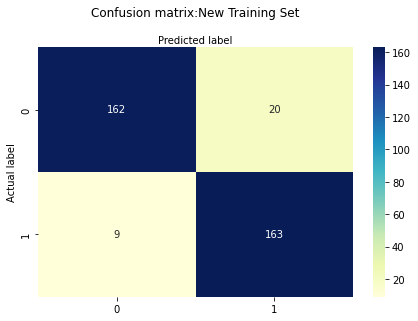

In [17]:
lr(x_non_archive_tfidf, y_non_archive_tfidf, 'New Training Set')
lr_training(x_non_archive_tfidf, y_non_archive_tfidf, 'New Training Set')

In [11]:
lr_cv(x_non_archive_tfidf, y_non_archive_tfidf, 2, 'average_precision', 'New Training Set')

New Training Set
MEAN PRECISION
0.9377190611656225
report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       526
           1       0.94      0.97      0.95       544

    accuracy                           0.95      1070
   macro avg       0.95      0.95      0.95      1070
weighted avg       0.95      0.95      0.95      1070



Twitter Training Set
MEAN PRECISION
0.9873762798962694
report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4379
           1       0.99      0.98      0.98      4379

    accuracy                           0.98      8758
   macro avg       0.98      0.98      0.98      8758
weighted avg       0.98      0.98      0.98      8758

Twitter Training Set
Accuracy: 0.9858180560359737 
Precision: 0.9820069204152249 
Recall: 0.9895397489539749


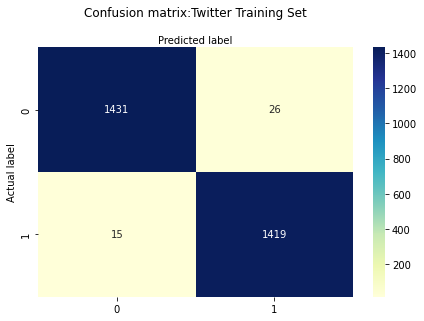

In [18]:
lr(x_twitter_tfidf, y_twitter_tfidf, 'Twitter Training Set')
lr_training(x_twitter_tfidf, y_twitter_tfidf, 'Twitter Training Set')

In [15]:
lr_cv(x_twitter_tfidf, y_twitter_tfidf, 5, 'precision', 'Twitter Training Set')

Twitter Training Set
MEAN PRECISION
0.988287307034135
report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4379
           1       0.99      0.98      0.98      4379

    accuracy                           0.98      8758
   macro avg       0.98      0.98      0.98      8758
weighted avg       0.98      0.98      0.98      8758

